In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [130]:
df = pd.read_csv(r'../../results/computed-fuel-rates-oct2021-sep2022-test-10222023.csv', delimiter=',', skiprows=0, low_memory=False)

In [131]:
validation= pd.read_excel(r'../../data/tidy/Jun2022-Sep2022-BEB-validation.xlsx')

In [132]:
df_beb=df[df['Powertrain'] == 'electric'].copy()

In [133]:
df_beb=df_beb[df_beb['Vehicle'] == 3501].copy()

In [134]:
validation['Date'] = pd.to_datetime(validation['Transaction Date'])

In [135]:
df_sum = df_beb.groupby('Date')[['Energy','dist']].sum().reset_index()
print(df_sum)

           Date      Energy       dist
0    2021-12-05   69.829407  34.661251
1    2022-01-11  145.566921  88.030070
2    2022-01-13  179.458087  97.085273
3    2022-01-18  122.078698  85.620361
4    2022-01-25  127.312915  79.121784
..          ...         ...        ...
119  2022-08-27   62.278244  70.667934
120  2022-08-29  138.383737  97.576880
121  2022-08-30   69.823489  70.667934
122  2022-08-31  110.774408  84.326695
123  2022-09-29   83.989303  34.623857

[124 rows x 3 columns]


In [136]:
# Make sure 'Date' columns are in datetime format
validation['Date'] = pd.to_datetime(validation['Date'])
df_sum['Date'] = pd.to_datetime(df_sum['Date'])

# Merge df_sum into validation on 'Date'
# Merge df_sum into validation on 'Date'
validation = validation.merge(df_sum[['Date', 'Energy', 'dist']], on='Date', how='left')
validation

,Equipment ID,Qty,Transaction Date,Date,Energy,dist
0,3501,26.7,2022-06-01,2022-06-01,27.655376,15.759902
1,3501,167.1,2022-06-02,2022-06-02,174.732613,96.860943
2,3501,30.2,2022-06-03,2022-06-03,NaN,NaN
3,3501,173.9,2022-06-06,2022-06-06,155.446605,97.573532
4,3501,74.3,2022-06-07,2022-06-07,53.221807,44.210750
5,3501,81.4,2022-06-08,2022-06-08,94.988040,43.615372
6,3501,111.2,2022-06-09,2022-06-09,90.628417,68.790781
7,3501,224.3,2022-06-10,2022-06-10,144.090619,97.510752
8,3501,134.3,2022-06-12,2022-06-12,NaN,NaN
9,3501,168.9,2022-06-13,2022-06-13,155.987684,97.574648


In [137]:
validation.dropna(subset=['Energy'], inplace=True)
validation

,Equipment ID,Qty,Transaction Date,Date,Energy,dist
0,3501,26.7,2022-06-01,2022-06-01,27.655376,15.759902
1,3501,167.1,2022-06-02,2022-06-02,174.732613,96.860943
3,3501,173.9,2022-06-06,2022-06-06,155.446605,97.573532
4,3501,74.3,2022-06-07,2022-06-07,53.221807,44.210750
5,3501,81.4,2022-06-08,2022-06-08,94.988040,43.615372
6,3501,111.2,2022-06-09,2022-06-09,90.628417,68.790781
7,3501,224.3,2022-06-10,2022-06-10,144.090619,97.510752
9,3501,168.9,2022-06-13,2022-06-13,155.987684,97.574648
10,3501,76.1,2022-06-14,2022-06-14,45.116446,44.237586
11,3501,205.7,2022-06-15,2022-06-15,35.490392,70.551210


In [138]:
validation['residual']=validation['Qty']-validation['Energy']

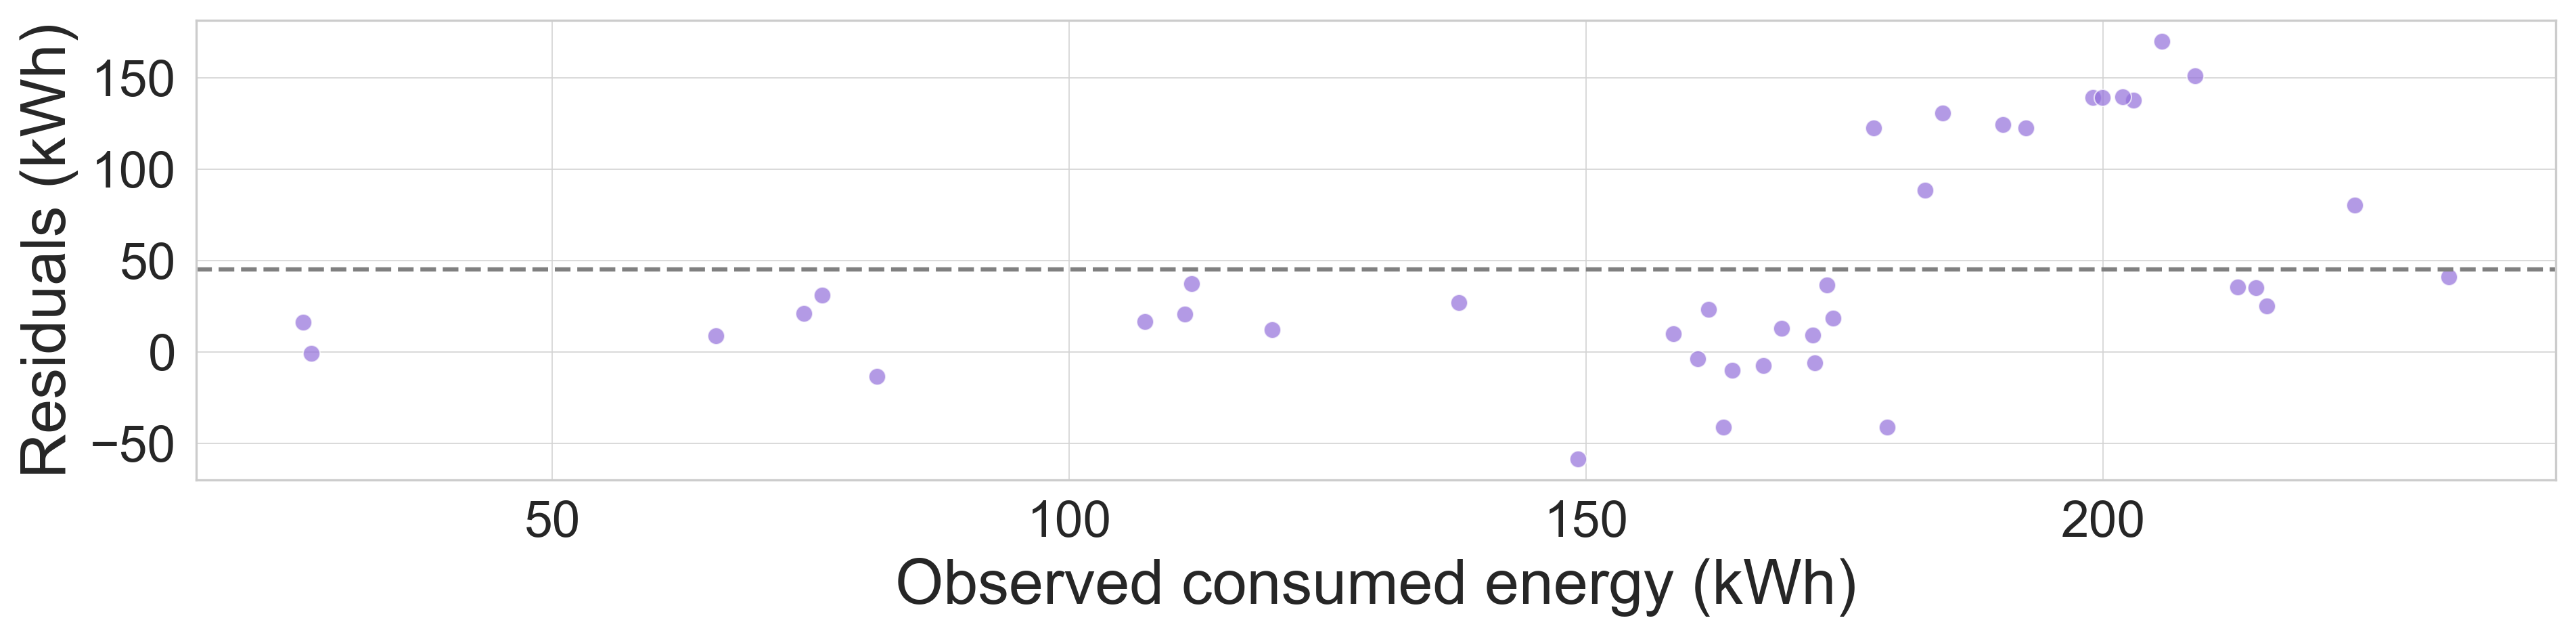

In [139]:
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

sns.set_style("whitegrid")

#sns.scatterplot(x='gallons', y='residual', data=df_conventional, hue='VehicleModel', alpha=0.7)
sns.scatterplot(x='Qty', y='residual', data=validation, color='mediumpurple', alpha=0.7)
plt.axhline(validation['residual'].mean(),color='gray', linestyle='--')
plt.ylabel('Residuals (kWh)', fontsize=22)
plt.xlabel('Observed consumed energy (kWh)', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Set plot area color
ax.set_facecolor('white')
ax.grid(color='lightgrey', linewidth=0.4)
#fig.savefig(r'../../figures/residuals-vs-consumed-energy-conventional.png', dpi=400, bbox_inches='tight')

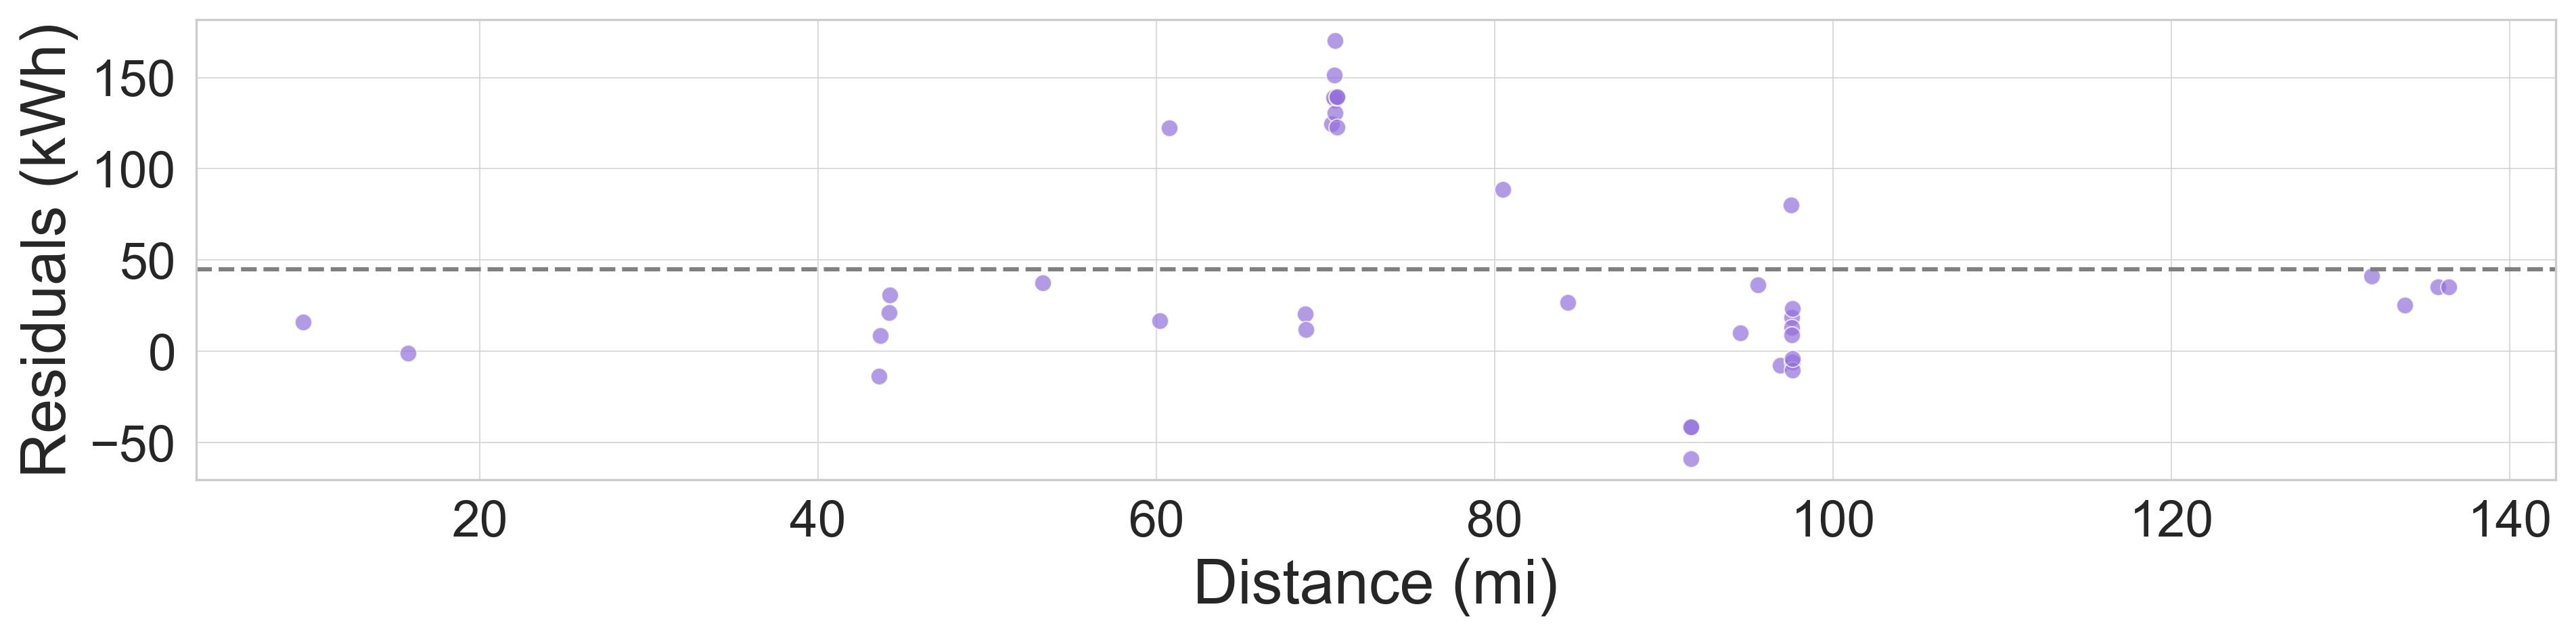

In [140]:
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

sns.set_style("whitegrid")

#sns.scatterplot(x='dist', y='residual', data=df_conventional, hue='VehicleModel', alpha=0.7)
sns.scatterplot(x='dist', y='residual', data=validation, color='mediumpurple', alpha=0.7)
plt.axhline(validation['residual'].mean(),color='gray', linestyle='--')
plt.ylabel('Residuals (kWh)', fontsize=22)
plt.xlabel('Distance (mi)', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.grid(color='lightgrey', linewidth=0.4)
#plt.plot(df_conventional['residual'].mean(), linewidth=2)
#fig.savefig(r'../../figures/residuals-vs-dist-conventional.png', dpi=400, bbox_inches='tight')

In [141]:
validation['economy']=validation['dist']/validation['Energy']

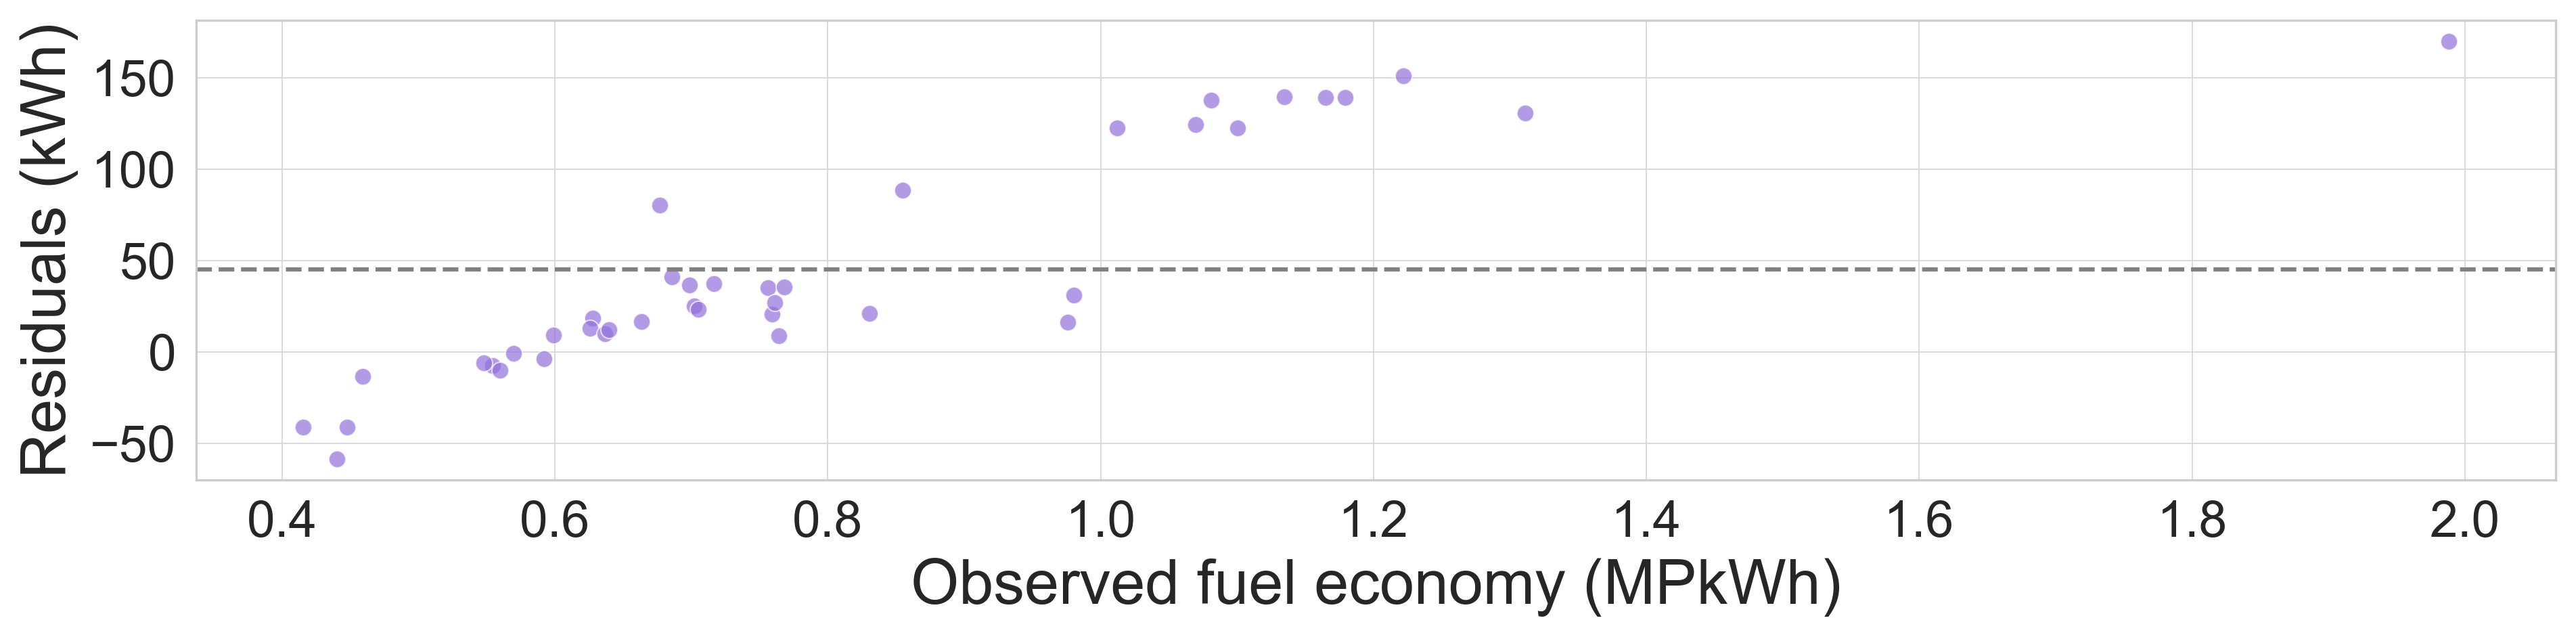

In [142]:
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

sns.set_style("whitegrid")

#sns.scatterplot(x='gallons', y='residual', data=df_conventional, hue='VehicleModel', alpha=0.7)
sns.scatterplot(x='economy', y='residual', data=validation, color='mediumpurple', alpha=0.7)
plt.axhline(validation['residual'].mean(),color='gray', linestyle='--')
plt.ylabel('Residuals (kWh)', fontsize=22)
plt.xlabel('Observed fuel economy (MPkWh)', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Set plot area color
ax.set_facecolor('white')
ax.grid(color='lightgrey', linewidth=0.4)
#fig.savefig(r'../../figures/residuals-vs-consumed-energy-conventional.png', dpi=400, bbox_inches='tight')

In [143]:
from sklearn.metrics import mean_squared_error
import numpy as np

observed = validation['Energy']
predicted = validation['Qty']

rmse = np.sqrt(mean_squared_error(observed, predicted))
print('RMSE:', rmse)

RMSE: 75.05863129056011


In [144]:
validation['Qty'].mean()

158.73000000000002

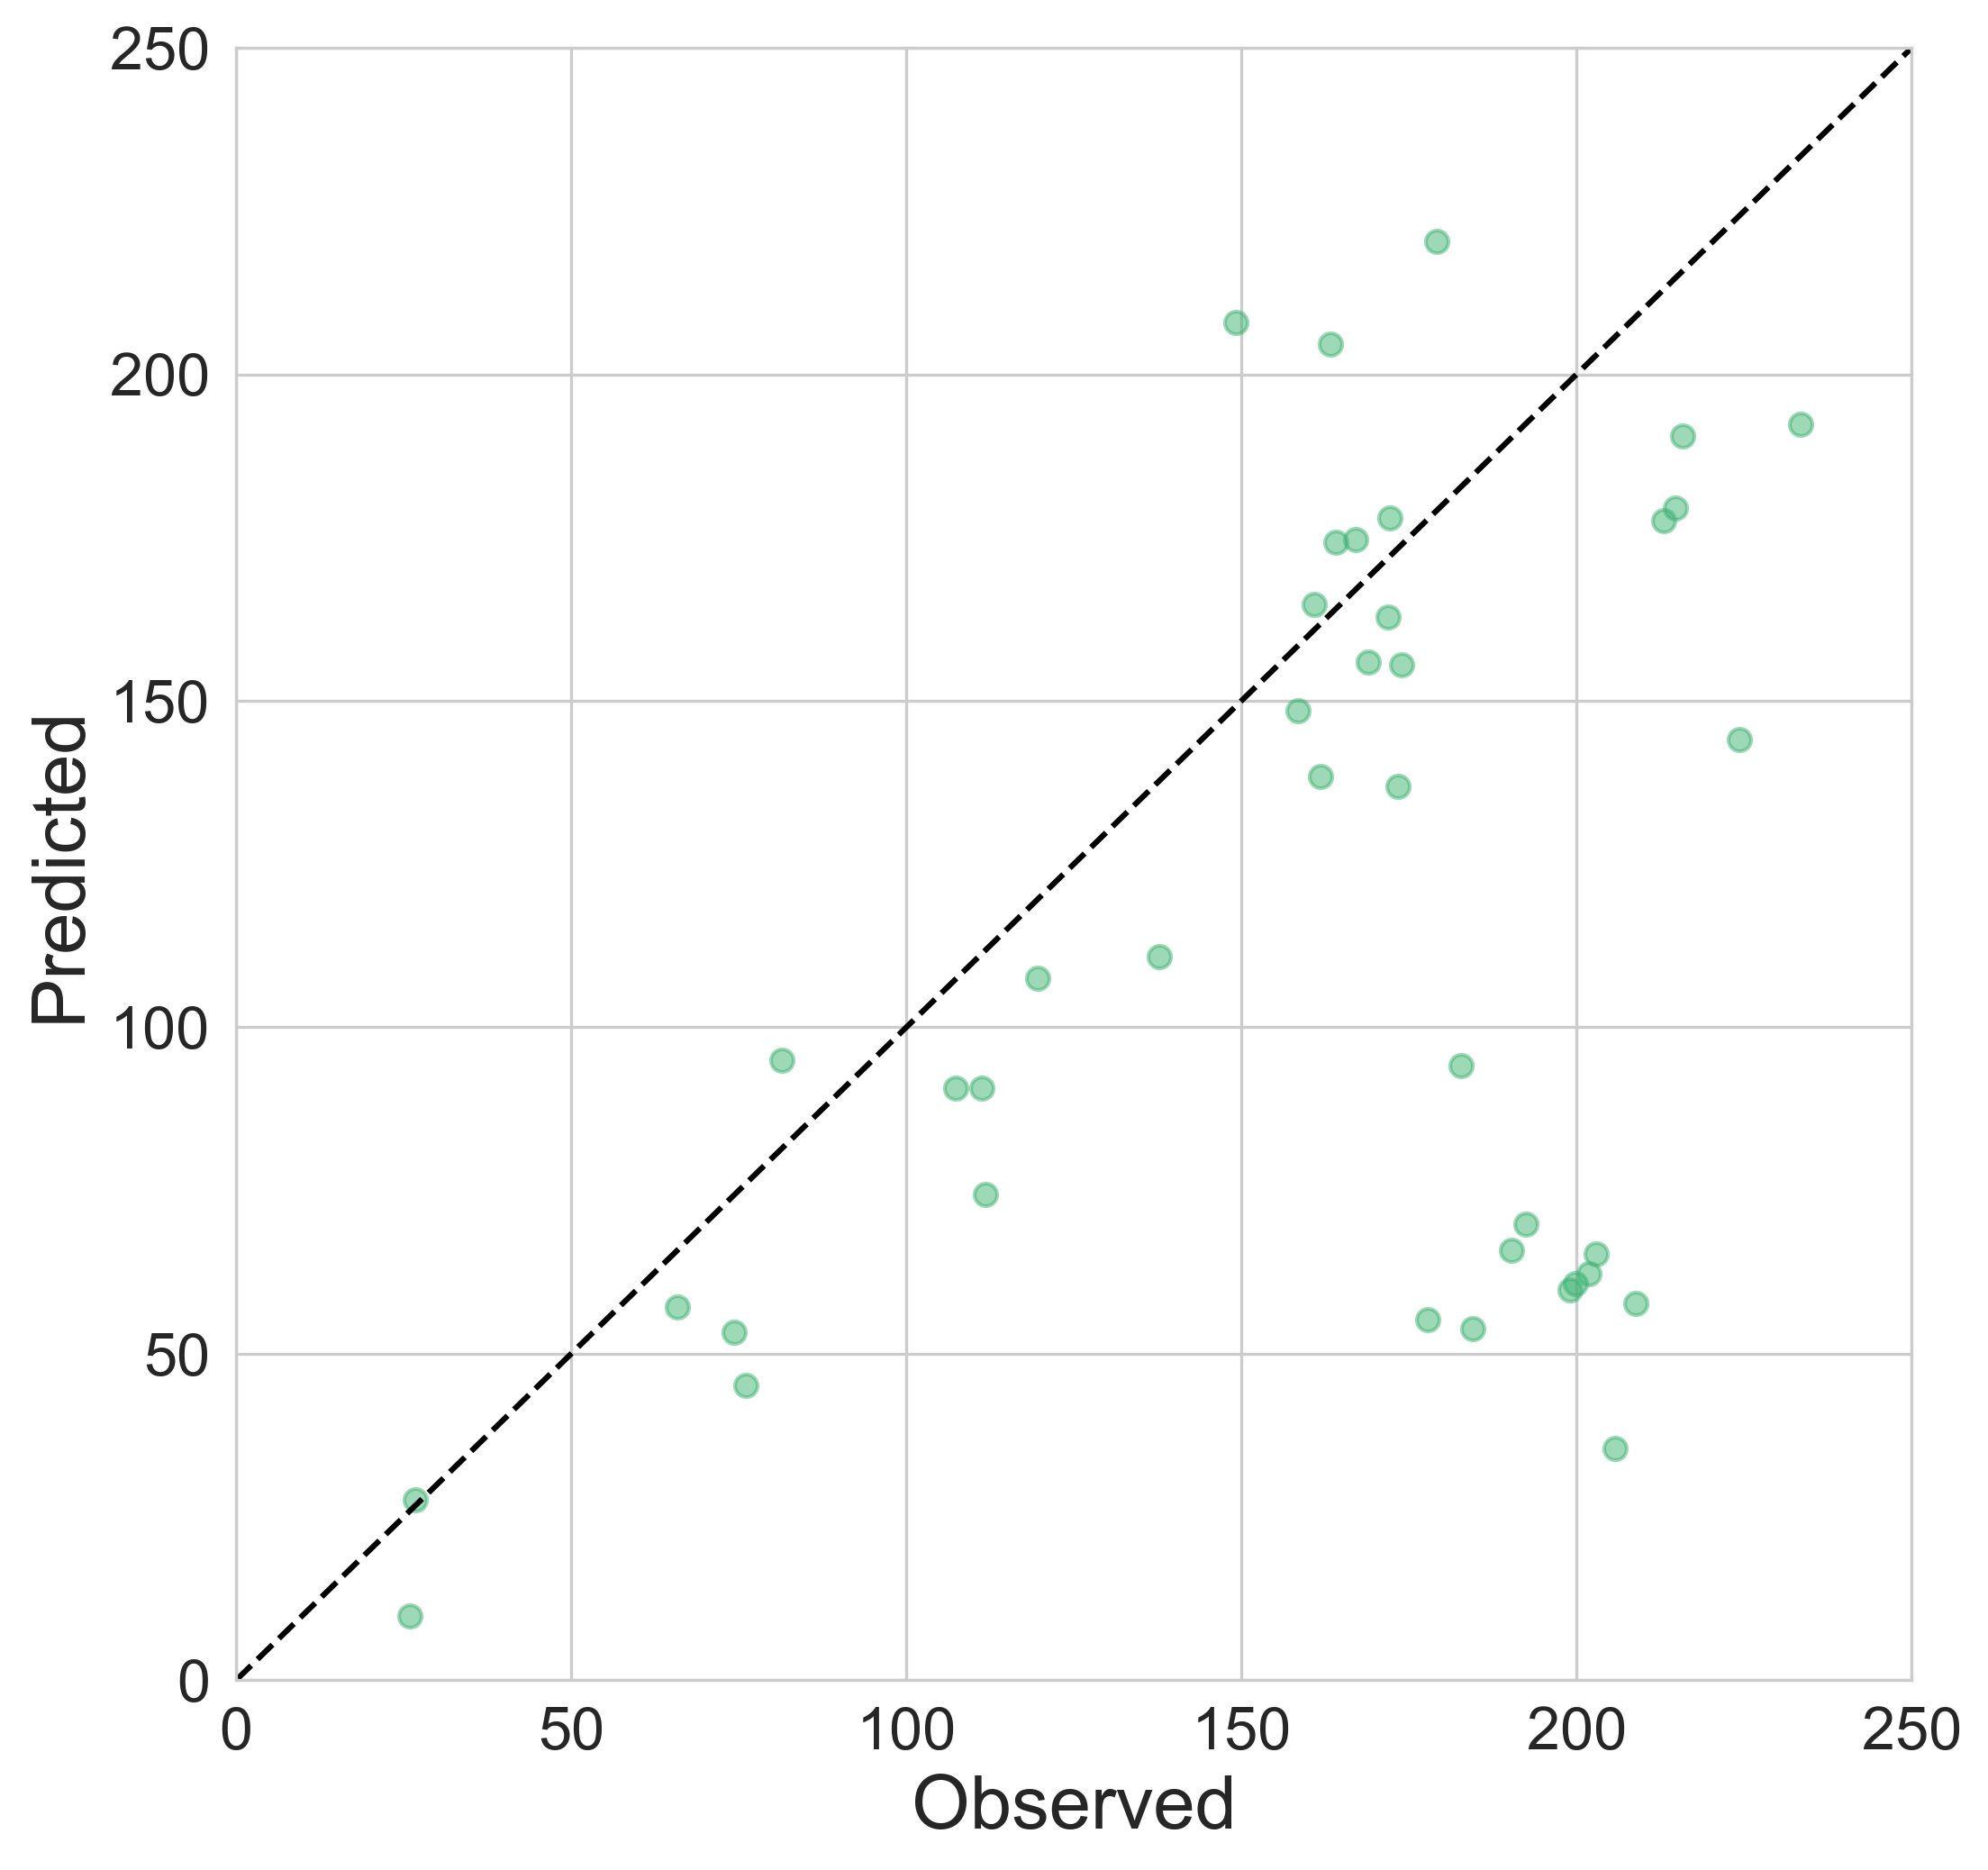

In [145]:
# create a new figure with specified size and DPI
fig = plt.figure(figsize=(8, 8), dpi=300)

# create a scatter plot of predicted vs observed
plt.scatter(validation['Qty'], validation['Energy'], alpha=0.5, color='mediumseagreen')

# Calculate the minimum and maximum limits for x and y axes
xlim = ylim = (0, 250)
xy_min = min(xlim[0], ylim[0])
xy_max = max(xlim[1], ylim[1])

# add a reference line showing perfect agreement between predicted and observed values
plt.plot([xy_min, xy_max], [xy_min, xy_max], color='black', linestyle='dashed')

# set the axis limits
plt.xlim(xlim)
plt.ylim(ylim)

# set the axis labels
plt.ylabel('Predicted', fontsize=20)
plt.xlabel('Observed', fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# show the plot
plt.show()

# Saving
fig.savefig(r'../../figures/BEB-observed-vs-predicted-sep2021-oct2022.png', dpi=300, bbox_inches='tight')

In [146]:
validation

,Equipment ID,Qty,Transaction Date,Date,Energy,dist,residual,economy
0,3501,26.7,2022-06-01,2022-06-01,27.655376,15.759902,-0.955376,0.569868
1,3501,167.1,2022-06-02,2022-06-02,174.732613,96.860943,-7.632613,0.554338
3,3501,173.9,2022-06-06,2022-06-06,155.446605,97.573532,18.453395,0.627698
4,3501,74.3,2022-06-07,2022-06-07,53.221807,44.210750,21.078193,0.830689
5,3501,81.4,2022-06-08,2022-06-08,94.988040,43.615372,-13.588040,0.459167
6,3501,111.2,2022-06-09,2022-06-09,90.628417,68.790781,20.571583,0.759042
7,3501,224.3,2022-06-10,2022-06-10,144.090619,97.510752,80.209381,0.676732
9,3501,168.9,2022-06-13,2022-06-13,155.987684,97.574648,12.912316,0.625528
10,3501,76.1,2022-06-14,2022-06-14,45.116446,44.237586,30.983554,0.980520
11,3501,205.7,2022-06-15,2022-06-15,35.490392,70.551210,170.209608,1.987896


In [147]:
validation['Transaction Date'] = pd.to_datetime(validation['Transaction Date'])
validation = validation.set_index('Transaction Date')
validation = validation[['Energy','Qty']].resample('W').sum()
validation=validation.reset_index()

In [148]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named 'df'
train_validation, test_validation = train_test_split(validation, test_size=0.2, random_state=42)

In [149]:
validation

,Transaction Date,Energy,Qty
0,2022-06-05,202.387989,193.8
1,2022-06-12,538.375488,665.1
2,2022-06-19,467.579402,806.8
3,2022-06-26,300.432484,440.8
4,2022-07-03,564.555197,752.9
5,2022-07-10,248.293593,424.7
6,2022-07-17,0.000000,0.0
7,2022-07-24,0.000000,0.0
8,2022-07-31,0.000000,0.0
9,2022-08-07,666.596036,924.8


In [150]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_validation['Qty'], test_validation['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_validation['Qty'], test_validation['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.17
RMSE: 151.03


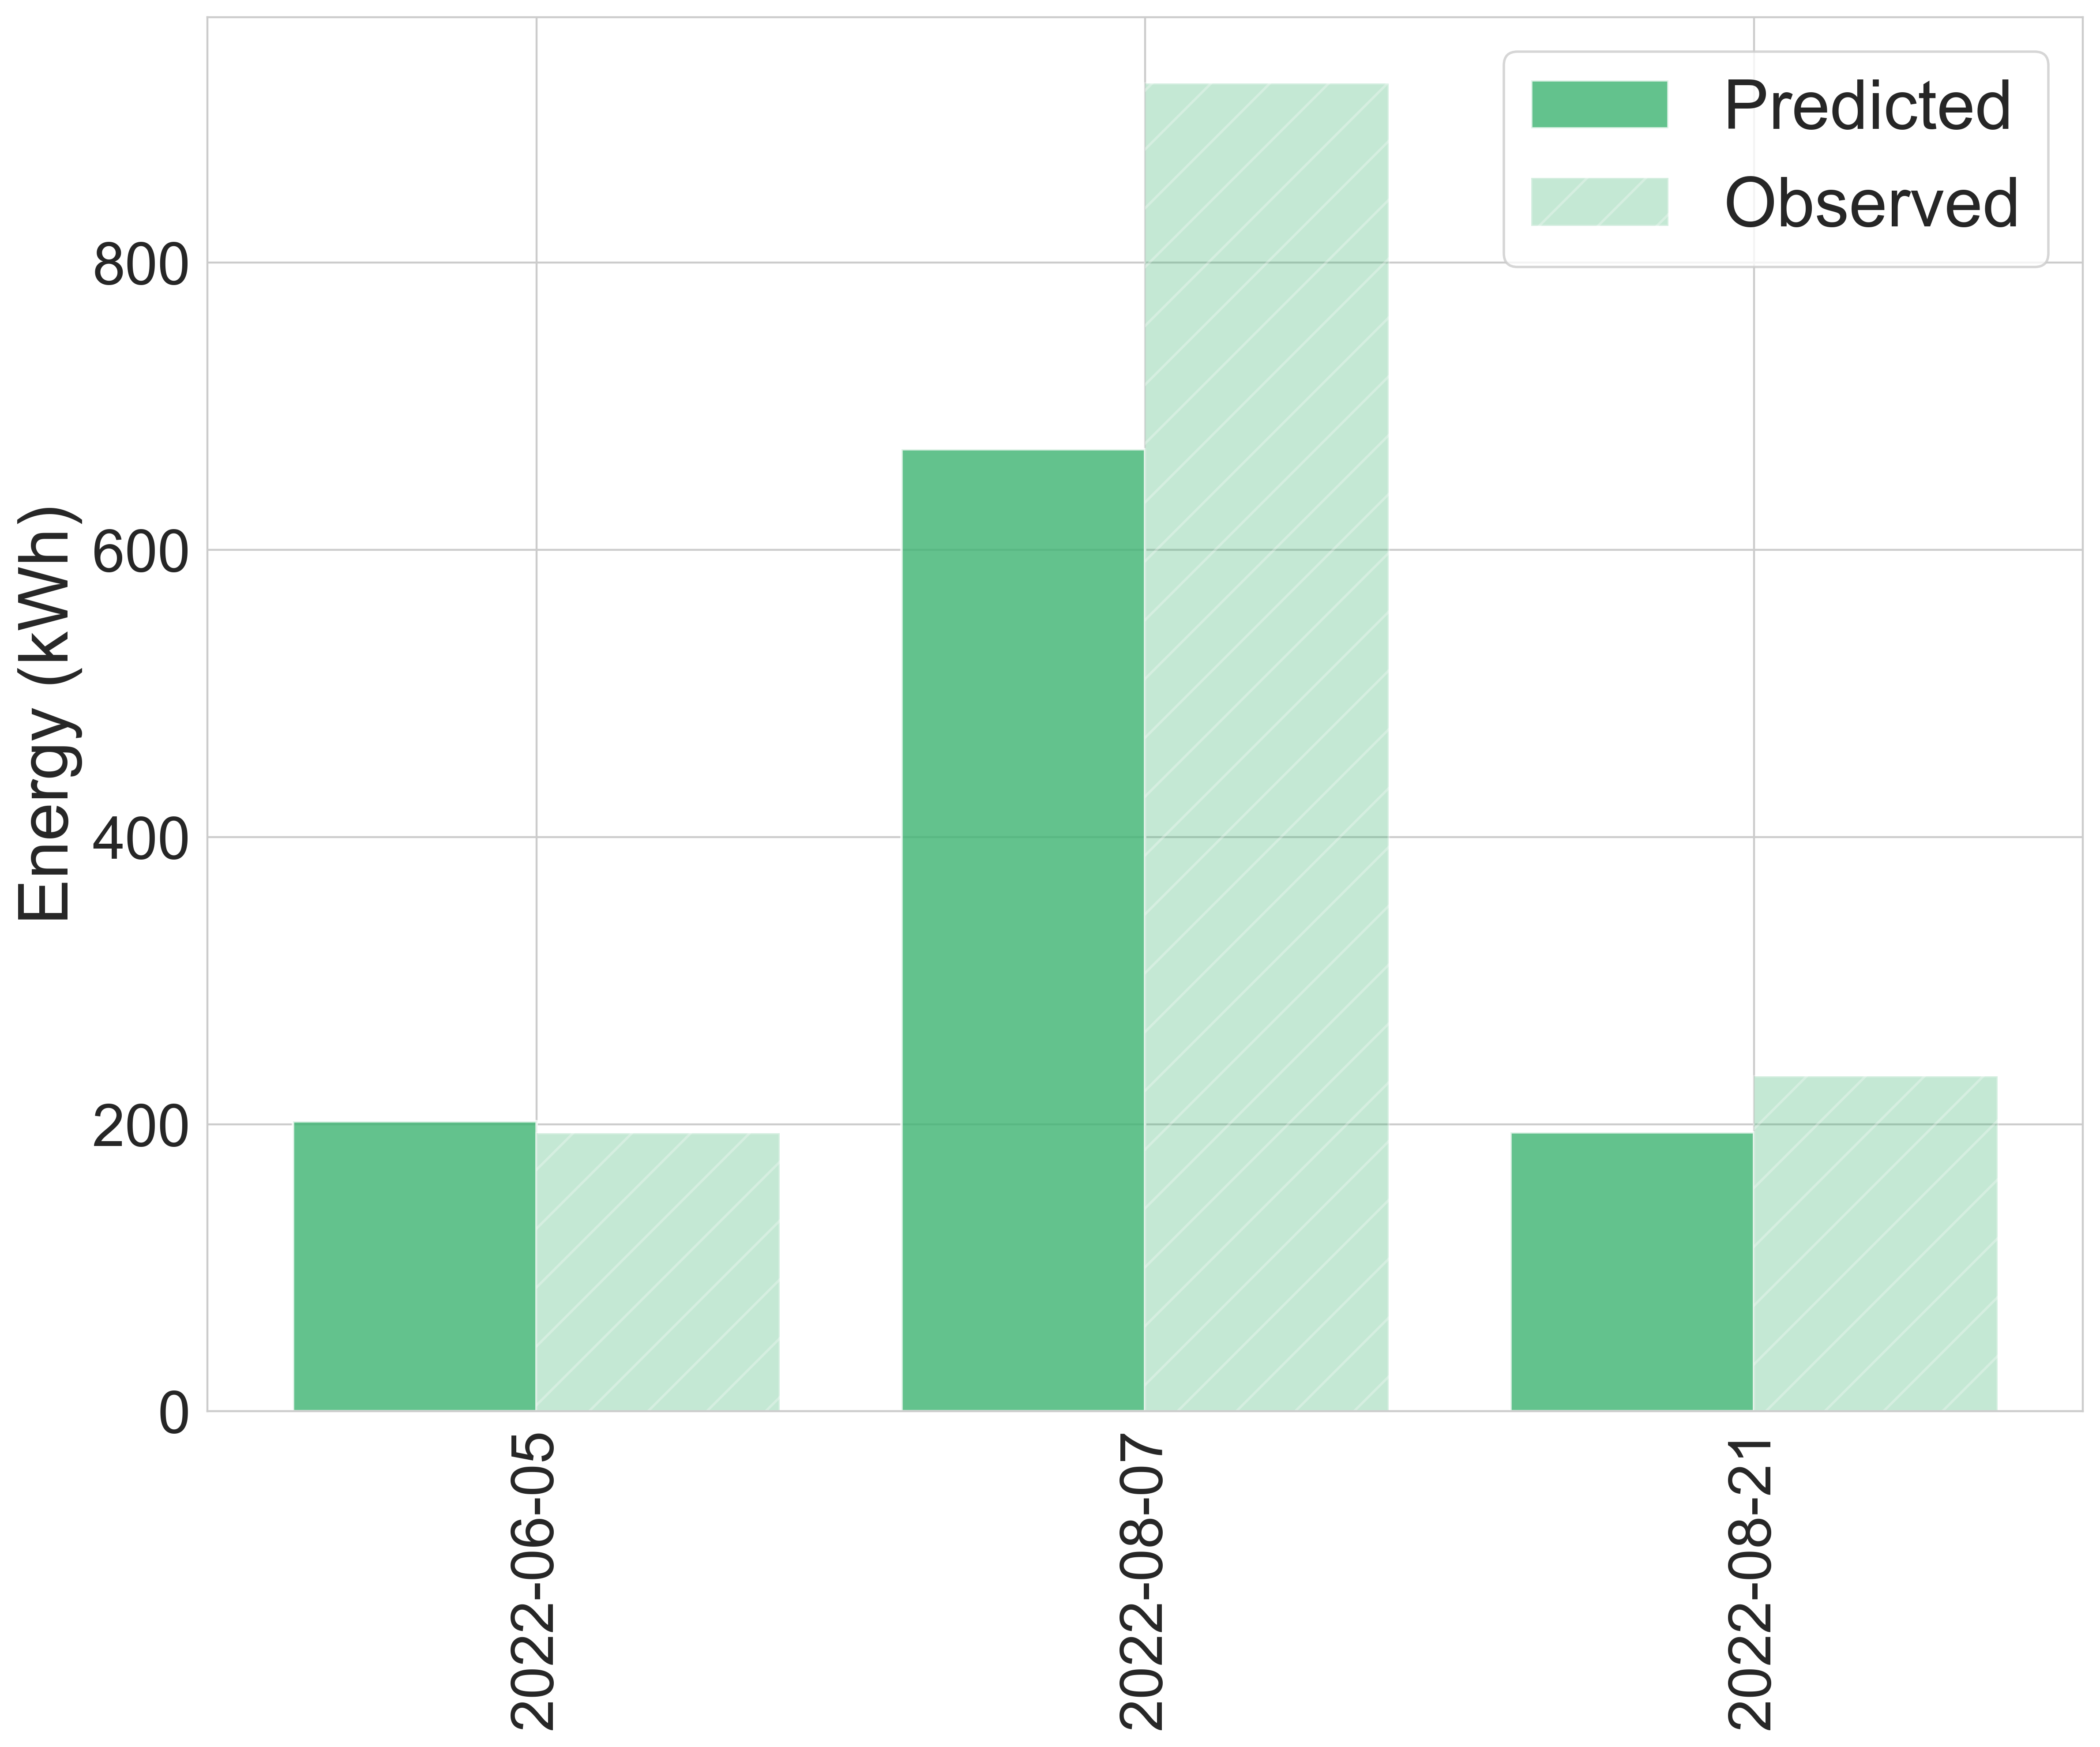

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'ServiceDateTime' is a datetime object
test_validation['Transaction Date'] = pd.to_datetime(test_validation['Transaction Date'])
test_validation = test_validation.sort_values('Transaction Date')


# Set 'ServiceDateTime' as index for plotting purposes
test_validation.set_index('Transaction Date', inplace=True)

# Create an array with the position of each bar along the x-axis
x = np.arange(len(test_validation))

# Set the width of the bars
bar_width = 0.4

plt.figure(figsize=(12, 10), dpi=400)

# Plot 'Predicted' bars
plt.bar(x - bar_width/2, test_validation['Energy'], width=bar_width, color='mediumseagreen', alpha=0.8, label='Predicted')

# Plot 'Observed' bars
plt.bar(x + bar_width/2, test_validation['Qty'], width=bar_width, color='mediumseagreen', alpha=0.3, hatch='/', label='Observed')

# Put the x-axis labels (ServiceDateTime) using the index values
plt.xticks(x, test_validation.index.strftime('%Y-%m-%d'), rotation=90, fontsize=24)
plt.yticks(fontsize=24)


plt.ylabel('Energy (kWh)', fontsize=28)
plt.legend(fontsize=28)
plt.tight_layout() 

# Save the figure with high resolution
plt.savefig(r'../../figures/validation-BEB-Oct2021-Sep2022.png', dpi=400, bbox_inches='tight')
plt.show()


In [127]:
test_validation

,Energy,Qty
Transaction Date,,
2022-06-05,202.128138,193.8
2022-08-07,669.995465,924.8
2022-08-21,194.290445,233.4


In [128]:
validation

,Transaction Date,Energy,Qty
0,2022-06-05,202.128138,193.8
1,2022-06-12,547.569396,665.1
2,2022-06-19,493.450433,806.8
3,2022-06-26,304.737114,440.8
4,2022-07-03,580.206552,752.9
5,2022-07-10,256.241349,424.7
6,2022-07-17,0.000000,0.0
7,2022-07-24,0.000000,0.0
8,2022-07-31,0.000000,0.0
9,2022-08-07,669.995465,924.8
